In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import sys

# import utils
sys.path.append("../")
sys.path.append("../data_loading")

import plotting
from plotting import mimic_r_boxplot

from data_loading import (load_y2h_isoform_data, 
    load_m1h_activation_data, 
    load_ppi_partner_categories, 
    load_annotated_TFiso1_collection,
    load_human_tf_db,
    load_y1h_pdi_data)

from isoform_pairwise_metrics import load_ref_vs_alt_isoforms_table, _add_PPI_columns

In [2]:
PAPER_PRESET = {"style": "ticks", "font": "Helvetica", "context": "paper", 
                "rc": {"font.size":7,"axes.titlesize":7,
                       "axes.labelsize":7, 'axes.linewidth':0.5,
                       "legend.fontsize":6, "xtick.labelsize":6,
                       "ytick.labelsize":6, "xtick.major.size": 3.0,
                       "ytick.major.size": 3.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 7

In [3]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## 1. load TFs, assay data (Y2H, M1H), Pfam domains, and PPI partner categories/cofactors

In [4]:
tfs = load_annotated_TFiso1_collection()
pairs = load_ref_vs_alt_isoforms_table()

# RORC-1 alt iso is causing an error - filter out here - there's no data for it?
pairs = pairs[pairs["clone_acc_alt"] != "RORC|1/6|05F11"]

pairs['ref_iso'] = pairs['clone_acc_ref'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
pairs['alt_iso'] = pairs['clone_acc_alt'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
pairs['f_disorder_difference'] = pairs.apply(lambda x: tfs[x['gene_symbol']].disordered_fraction_of_different_regions(x['ref_iso'], x['alt_iso']), axis=1)

reading from cache


In [5]:
y2h = load_y2h_isoform_data()
m1h = load_m1h_activation_data()
m1h['mean'] = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)
cats = load_ppi_partner_categories()

In [6]:
df = pd.read_excel('../../data/external/Geiger-et-al_MCP_2012_Supplementary-Table-2.xlsx',
                   skiprows=1)
hek_avrg = df[['iBAQ HEK293_1', 'iBAQ HEK293_2', 'iBAQ HEK293_3']].mean(axis=1)
print((hek_avrg > 0).sum(), 'proteins expressed in HEK293 proteome')
hek_expressed_genes = set(df.loc[(hek_avrg > 0) & df['Gene Names'].notnull(),
       'Gene Names'].str.split(';').explode().values)
all_partners = set(y2h['db_gene_symbol'].unique())
print('of {} PPI partners, {} are expressed in HEK293 cells'.format(len(all_partners), 
      len(all_partners.intersection(hek_expressed_genes))))

8543 proteins expressed in HEK293 proteome
of 500 PPI partners, 252 are expressed in HEK293 cells


In [7]:
# now add Pfam AD/RDs
pfam = pd.read_csv('../../data/external/Pfam-A.clans.tsv',
                   sep='\t',
                   names=['pfam_accession', 'clan', 'clan_name', 'short_name', 'name'])

In [8]:
cof = pd.read_csv('../../data/external/AnimalTFDB3_Homo_sapiens_TF_cofactors.txt',
                 sep='\t')
if cof['Symbol'].duplicated().any():
    raise UserWarning('unexpected duplicates')

## 2. categorize effector domain changes between alt/ref iso

In [9]:
dom = pd.concat([g.aa_feature_disruption(g.cloned_reference_isoform.name) for g in tfs.values()])

# add activation or repression annotation from effector domain studies
effector_domain_type = {}
for tf in tfs.values():
    for d in tf.cloned_reference_isoform.aa_seq_features:
        if d.category == 'effector_domain':
            effector_domain_type[d.accession] = d.name
dom['type'] = dom['accession'].map(effector_domain_type)

In [10]:
# add activation or repression annotation from Pfam domains directly
pfam_ad = pfam[(pfam['name'].str.contains("transcription activation")) | 
               (pfam['name'].str.contains("transactivation")) |
               (pfam['short_name'].str.contains("TAD"))].copy()
pfam_ad["type"] = "AD"

# RD
pfam_rd = pfam[(pfam['short_name'].str.contains("NRIP1_repr")) | 
               (pfam['name'].str.contains("KRAB"))].copy()
pfam_rd["type"] = "RD"
pfam_effs = pd.concat([pfam_ad, pfam_rd])

def get_pfam_type(row):
    if not pd.isnull(row['type']):
        return row['type']
    else:
        pfam_sub = pfam_effs[pfam_effs['pfam_accession'] == row['accession']]
        if len(pfam_sub) > 0:
            return pfam_sub['type'].iloc[0]
        else:
            return np.nan
dom["type_incl_pfam"] = dom.apply(get_pfam_type, axis=1)

In [11]:
# considering Pfam and Effector domains
def fraction_of_effector_domains_removed(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type_incl_pfam'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds[['deletion', 'frameshift']].sum().sum() / ds['length'].sum()


def insertion_in_effector_domains(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type_incl_pfam'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['insertion'].sum()

def domain_length(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type_incl_pfam'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['length'].sum()


for effector_type in ['AD', 'RD', 'Bif']:
    pairs['fraction_of_{}_domains_removed_incl_pfam'.format(effector_type)] = pairs.apply(fraction_of_effector_domains_removed, effector_type=effector_type, axis=1)
    pairs['insertion_in_{}_domains_incl_pfam'.format(effector_type)] = pairs.apply(insertion_in_effector_domains, effector_type=effector_type, axis=1)
    pairs['length_of_{}_domains_incl_pfam'.format(effector_type)] = pairs.apply(domain_length, effector_type=effector_type, axis=1)

## 3. plot number of annotated domains (of various types) across isoforms

Text(0.5, 0, 'Effector domains in reference isoform')

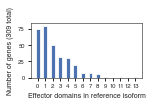

In [12]:
# plot of number of activation domains per ref iso
# fraction of sequnce within effector domains
def count_effector_domains(gene):
    iso = gene.cloned_reference_isoform
    c = 0
    for d in iso.aa_seq_features:
        if d.category == 'effector_domain':
            c += 1
    return c

n_effector = [count_effector_domains(tf) for tf in tfs.values()]

fig, ax = plt.subplots(1, 1, figsize=(2, 1))
ax.hist(n_effector,
        range=(-0.25, max(n_effector) + 0.25),
          bins=(max(n_effector) * 2 + 1))
ax.set_xticks(range(max(n_effector) + 1))
ax.set_ylabel('Number of genes ({} total)'.format(len(tfs)))
ax.set_xlabel('Effector domains in reference isoform')

Text(0.5, 1.0, 'Soto et al. data')

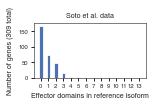

In [13]:
# plot of number of activation domains per ref iso
# fraction of sequnce within effector domains
def count_Soto_effector_domains(gene):
    iso = gene.cloned_reference_isoform
    c = 0
    for d in iso.aa_seq_features:
        if d.category == 'effector_domain' and d.accession.startswith('Soto'):
            c += 1
    return c

n_effector_soto = [count_Soto_effector_domains(tf) for tf in tfs.values()]

fig, ax = plt.subplots(1, 1, figsize=(2, 1))
ax.hist(n_effector_soto,
        range=(-0.25, max(n_effector) + 0.25),
          bins=(max(n_effector) * 2 + 1))
ax.set_xticks(range(max(n_effector) + 1))
ax.set_ylabel('Number of genes ({} total)'.format(len(tfs)))
ax.set_xlabel('Effector domains in reference isoform')
ax.set_title('Soto et al. data')

Text(0.5, 1.0, 'Data from Bintu lab papers')

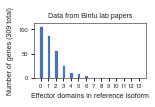

In [14]:
# plot of number of activation domains per ref iso
# fraction of sequnce within effector domains
def count_Bintu_effector_domains(gene):
    iso = gene.cloned_reference_isoform
    c = 0
    for d in iso.aa_seq_features:
        if d.category == 'effector_domain' and not d.accession.startswith('Soto'):
            c += 1
    return c

n_effector_bintu = [count_Bintu_effector_domains(tf) for tf in tfs.values()]

fig, ax = plt.subplots(1, 1, figsize=(2, 1))
ax.hist(n_effector_bintu,
        range=(-0.25, max(n_effector) + 0.25),
          bins=(max(n_effector) * 2 + 1))
ax.set_xticks(range(max(n_effector) + 1))
ax.set_ylabel('Number of genes ({} total)'.format(len(tfs)))
ax.set_xlabel('Effector domains in reference isoform')
ax.set_title('Data from Bintu lab papers')

In [15]:
counter = {'Soto': {'AD': 0, 'RD': 0, 'Bif': 0},
           'Tycko': {'AD': 0, 'RD': 0},
           'DelRosso': {'AD': 0, 'RD': 0}}
for tf in tfs.values():
    has_effector = False
    for domain in tf.cloned_reference_isoform.aa_seq_features:
        if domain.category == 'effector_domain':
            counter[domain.accession.split('_')[0]][domain.name] += 1
counter

{'Soto': {'AD': 156, 'RD': 80, 'Bif': 4},
 'Tycko': {'AD': 4, 'RD': 48},
 'DelRosso': {'AD': 37, 'RD': 345}}

Text(0, 0.5, 'Number of effector domains')

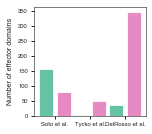

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.bar(x=range(6),
       height=[counter[x][y] for x in counter.keys() for y in ['AD', 'RD']],
       color=[sns.color_palette("Set2")[0], sns.color_palette("Set2")[3]] * 3)
ax.set_xticks([0.5, 2.5, 4.5])
ax.set_xticklabels(['Soto et al.', 'Tycko et al.', 'DelRosso et al.'])
ax.set_ylabel('Number of effector domains')

## 4. summary plot looking at gain/loss of domains and activity

In [17]:
m1h['gte_2_fold'] = (m1h['mean'].abs() >= 1)
pairs['m1h_gte_2_fold_at_least_one_iso_per_gene'] = pairs['gene_symbol'].map(m1h.groupby('gene_symbol')
                                                                             ['gte_2_fold']
                                                                             .any())
pairs['abs_activation_fold_change_log2'] = pairs['activation_fold_change_log2'].abs()

In [18]:
# create a color map of domain length
# sum up lengths of all domains (plot only includes examples w 1 type of domain)
pairs['tot_dom_length_incl_pfam'] = pairs[['length_of_AD_domains_incl_pfam', 'length_of_RD_domains_incl_pfam', 'length_of_Bif_domains_incl_pfam']].sum(axis=1)
t_dom_length_incl_pfam = pairs.loc[:,'tot_dom_length_incl_pfam'].values
t_dom_length_incl_pfam = t_dom_length_incl_pfam[t_dom_length_incl_pfam > 0]

# using min and max makes colors too hard too read - cut off
cmap = sns.color_palette("flare", as_cmap=True)
norm = plt.Normalize(25, 250)
palette_dom_length_incl_pfam = {value: cmap(norm(value)) for value in t_dom_length_incl_pfam}

def re_color(row, palette):
    if row['tot_dom_length_incl_pfam'] == 0:
        color = sns.color_palette("flare")[0]
    else:
        color = palette[row['tot_dom_length_incl_pfam']]
    return color

pairs["color_dom_length_incl_pfam"] = pairs.apply(re_color, axis=1, palette=palette_dom_length_incl_pfam)

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 31.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


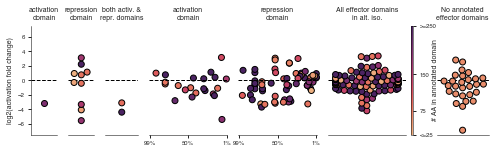

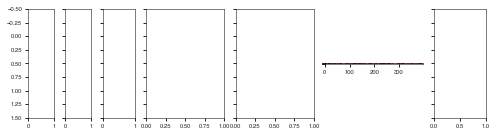

In [20]:
df = pairs.copy()
df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]
palette = palette_dom_length_incl_pfam
hue = 'tot_dom_length_incl_pfam'
color = 'color_dom_length_incl_pfam'
t = t_dom_length_incl_pfam

gs_kw = dict(width_ratios=[0.4, 0.4, 0.5, 1.2, 1.2, 1.5, 0.8])

fig, axs = plt.subplots(1, 7, sharey=True, gridspec_kw=gs_kw)
fig.set_size_inches(w=8.2, h=2)

point_size = 6


tot_loss_activ = df.loc[(df['fraction_of_AD_domains_removed_incl_pfam'] == 1) 
                        & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | 
                           (df['fraction_of_RD_domains_removed_incl_pfam'] == 0))
                        & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                           (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)), :]
axs[0].set_title('activation\ndomain')
sns.swarmplot(data=tot_loss_activ,
              y='activation_fold_change_log2', 
              x='fraction_of_AD_domains_removed_incl_pfam',
              size=point_size,
            clip_on=False,
              ax=axs[0],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[0].set_xticks([])
axs[0].set_xlabel('')
axs[0].get_legend().remove()

tot_loss_repr = df.loc[(df['fraction_of_RD_domains_removed_incl_pfam'] == 1)
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_AD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)), :]
axs[1].set_title('repression\ndomain')
sns.swarmplot(data=tot_loss_repr,
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed_incl_pfam',
              size=point_size,
            clip_on=False,
              ax=axs[1],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[1].set_xticks([])
axs[1].set_xlabel('')
axs[1].get_legend().remove()


tot_loss_both = df.loc[(df['fraction_of_AD_domains_removed_incl_pfam'] == 1) &
                          (df['fraction_of_RD_domains_removed_incl_pfam'] == 1), :]
axs[2].set_title('both activ. &\nrepr. domains')
sns.swarmplot(data=tot_loss_both,
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed_incl_pfam',
              size=point_size,
            clip_on=False,
              ax=axs[2],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[2].set_xticks([])
axs[2].set_xlabel('')
axs[2].get_legend().remove()


# now partial loss
axs[3].set_title('activation\ndomain')
partial_loss_activ = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
              & (df['fraction_of_AD_domains_removed_incl_pfam'] > 0) 
                & (df['fraction_of_AD_domains_removed_incl_pfam'] < 1)
                        & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | 
                           (df['fraction_of_RD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))), :]
axs[3].scatter(partial_loss_activ.loc[:, 'fraction_of_AD_domains_removed_incl_pfam'].values,
               partial_loss_activ.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_activ.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[3].set_xlabel('')
axs[3].set_xlim(1, 0)
axs[3].set_xticks([0.99, 0.5, 0.01])
axs[3].set_xticklabels([f'{x:.0%}' for x in axs[3].get_xticks()])


axs[4].set_title('repression\ndomain')
partial_loss_repr = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
                & (df['fraction_of_RD_domains_removed_incl_pfam'] > 0)
                  &  (df['fraction_of_RD_domains_removed_incl_pfam'] < 1)
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_AD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))), :]

axs[4].scatter(partial_loss_repr.loc[:, 'fraction_of_RD_domains_removed_incl_pfam'].values,
               partial_loss_repr.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_repr.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[4].set_xlabel('')
axs[4].set_xlim(1, 0)
axs[4].set_xticks([0.99, 0.5, 0.01])
axs[4].set_xticklabels([f'{x:.0%}' for x in axs[4].get_xticks()])


all_retained = df.loc[((df['fraction_of_AD_domains_removed_incl_pfam'] == 0) |
                          (df['fraction_of_RD_domains_removed_incl_pfam'] == 0) |
                          (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | (df['fraction_of_AD_domains_removed_incl_pfam'] == 0)) 
                           & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | (df['fraction_of_RD_domains_removed_incl_pfam'] == 0)) 
                           & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)) 
                           ,
                           :]
axs[5].set_title('All effector domains\nin alt. iso.')
sns.swarmplot(data=all_retained,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[5],
               linewidth=1,
               edgecolor="black",
              alpha=1,
              hue=hue,
              palette=palette)
axs[5].set_xticks([])
axs[5].set_xlabel('')
axs[5].get_legend().remove()

# # annotate pbx1 and rfx3
# pbx1_y = df.loc[(df["clone_acc_alt"] == "PBX1|2/2|02C05"), 'activation_fold_change_log2'].values[0]
# rfx3_y = df.loc[(df["clone_acc_alt"] == "RFX3|3/5|08G08"), 'activation_fold_change_log2'].values[0]
# rfx4_y = df.loc[(df["clone_acc_alt"] == "RFX3|4/5|11D09"), 'activation_fold_change_log2'].values[0]
# for point in axs[4].collections:
#     for x, y in point.get_offsets():
#         if np.isclose(pbx1_y, y):
#             print("found: %s, %s" % (x, y))
#             axs[4].annotate("PBX1-2", xy=(x, y), xytext=(-10, -20), textcoords='offset points',
#                             arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.3"), 
#                             ha="center", va="top", fontsize=7,
#                             bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
#         if np.isclose(rfx3_y, y):
#             print("found: %s, %s" % (x, y))
#             axs[4].annotate("RFX3-3", xy=(x, y), xytext=(-8, -7), textcoords='offset points',
#                             arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.2"), 
#                             ha="center", va="top", fontsize=7,
#                             bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
#         if np.isclose(rfx4_y, y):
#             print("found: %s, %s" % (x, y))
#             axs[4].annotate("RFX3-4", xy=(x, y), xytext=(8, -8), textcoords='offset points',
#                             arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3"), 
#                             ha="center", va="top", fontsize=7,
#                             bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# missing stuff
incl = pd.concat([tot_loss_activ, 
                  tot_loss_repr, 
                  tot_loss_both, 
                  partial_loss_activ, 
                  partial_loss_repr, 
                  all_retained])

no_annot = df.loc[(~df.index.isin(incl.index.values)) & (pd.isnull(df["fraction_of_AD_domains_removed_incl_pfam"])) &
                  (pd.isnull(df["fraction_of_RD_domains_removed_incl_pfam"])) & 
                  (pd.isnull(df["fraction_of_Bif_domains_removed_incl_pfam"]))]
axs[6].set_title('No annotated\neffector domains')
sns.swarmplot(data=no_annot,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[6],
              linewidth=1,
               edgecolor="black",
              alpha=1,
              color=sns.color_palette("flare")[0])
axs[6].set_xticks([])
axs[6].set_xlabel('')


# add colorbar
# mirror figure
gs_kw = dict(width_ratios=[0.4, 0.4, 0.5, 1.2, 1.2, 1.5, 0.8])
fig2, axs2 = plt.subplots(1, 7, sharey=True, gridspec_kw=gs_kw)
fig2.set_size_inches(w=8.2, h=2)
map1 = axs2[5].imshow(np.stack([t, t]), cmap="flare", vmin=25, vmax=250)
cbar = fig.colorbar(map1, ax=axs[5], aspect=40)
cbar.set_ticks([25, 75, 150, 250])
cbar.set_ticklabels(["<=25", "75", "150", ">=250"])
cbar.set_label("# AA in annotated domain", labelpad=-4)


for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-7.5, 7.5)
    ax.axhline(y=0, color='black', linewidth=1, linestyle='dashed')
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.set_ylabel("")
axs[0].set_ylabel("log2(activation fold change)")
fig.savefig('../../figures/fig4/activation_vs_domain_removal_incl_pfam_colored_by_dom_length.pdf', bbox_inches='tight')

## 5. pie charts of PPI categories

In [21]:
len(cats)

1114

In [22]:
len(cats.gene_symbol_partner.unique())

987

In [23]:
cats.category.value_counts()

TF                     239
cofactor               165
signaling              141
other                  101
metabolism              81
cytoskeleton            77
protein turnover        60
RNA processing          59
vesicle transport       47
cell cycle              36
DNA repair              28
translation             20
cell-cell signaling     19
membrane protein        14
RNA turnover             9
nuclear transport        6
DNA polymerase           6
DNA replication          5
protein traffiking       1
Name: category, dtype: int64

In [24]:
y2h_nonan = y2h[~pd.isnull(y2h["Y2H_result"])]
len(y2h_nonan.db_gene_symbol.unique())

500

In [25]:
ggi = y2h_nonan[["ad_gene_symbol", "db_gene_symbol"]].drop_duplicates()
ggi

,ad_gene_symbol,db_gene_symbol
0,ATF2,ATF2
4,ATF2,JDP2
39,ATF2,FOSL2
73,ATF2,MAPK9
122,CREB5,EFEMP2
...,...,...
10218,TCF12,HEXIM2
10246,DDIT3,ZBTB25
10247,DDIT3,ZC3H14
10271,TCF12,EPHB6


In [26]:
# limiting df to those that are in the y2h iso data
cats_y2h = cats[cats["gene_symbol_partner"].isin(ggi["db_gene_symbol"])]
len(cats_y2h)

506

In [27]:
cats_dupe = cats_y2h.groupby("gene_symbol_partner")["category"].agg("count").reset_index()
cats_dupe[cats_dupe["category"] > 1].head()

,gene_symbol_partner,category
9,ARHGEF5,2
24,BARD1,3
48,CCNK,2
51,CDCA7L,2
53,CDK3,3


In [28]:
# keeping partners that are assigned more than 1 category for now...
cats_y2h[cats_y2h["gene_symbol_partner"] == "BARD1"]

,gene_symbol_partner,category,cofactor_type
30,BARD1,cofactor,both
31,BARD1,RNA processing,NaN
32,BARD1,DNA repair,NaN


In [29]:
def categorize_PPI_partner(row):
    if row['category'] == "TF":
        return 'TF'
    elif row['category'] == "cofactor":
        return 'cofactor'
    elif row['category'] == "signaling":
        return 'signaling'
    else:
        return 'other'
    
cats_y2h["partner_category"] = cats_y2h.apply(categorize_PPI_partner, axis=1)
cats_y2h.partner_category.value_counts()

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


other        235
TF           128
cofactor      78
signaling     65
Name: partner_category, dtype: int64

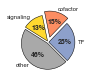

In [30]:
ys = np.array([len(cats_y2h[cats_y2h["partner_category"] == "TF"]), len(cats_y2h[cats_y2h["partner_category"] == "cofactor"]),
               len(cats_y2h[cats_y2h["partner_category"] == "signaling"]),
              len(cats_y2h[cats_y2h["partner_category"] == "other"])])
labels = ["TF", "cofactor", "signaling", "other"]
colors = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[1], sns.color_palette("Set2")[5], "darkgray"]

fig, ax = plt.subplots(figsize=(1.2, 1.2), subplot_kw=dict(aspect="equal"))
ws, ls, ns = ax.pie(ys, colors=colors, labels=labels, autopct='%1.0f%%', startangle=-45, 
                    explode=(0.02, 0.2, 0.05, 0.05))

for n, w in zip(ns, ws):
    w.set_linewidth(0.5)
    w.set_edgecolor("black")
    n.set_fontweight("bold")

fig.savefig("../../figures/fig4/PPIs-gene-level-manual-categories_simplified.pdf", dpi="figure", bbox_inches="tight")

In [31]:
cofactor_partners = set(cats_y2h.loc[cats_y2h['category'] == 'cofactor', 'gene_symbol_partner'].unique())
coactivator_partners = set(cats_y2h.loc[cats_y2h['cofactor_type'] == 'coactivator', 'gene_symbol_partner'].unique())
corepressor_partners = set(cats_y2h.loc[cats_y2h['cofactor_type'] == 'corepressor', 'gene_symbol_partner'].unique())
both_partners = set(cats_y2h.loc[cats_y2h['cofactor_type'] == 'both', 'gene_symbol_partner'].unique())
signaling_partners = set(cats_y2h.loc[cats_y2h['category'] == 'signaling', 'gene_symbol_partner'].unique())
cofactor_animal_db = set(cof['Symbol'].unique())
tf_gene_symbols = set(load_human_tf_db()['HGNC symbol'].values)

In [32]:
def categorize_cofactors(row):
    if row["partner_category"] == "cofactor":
        if row["gene_symbol_partner"] in both_partners:
            return "both"
        elif row["gene_symbol_partner"] in coactivator_partners:
            return "coactivator"
        elif row["gene_symbol_partner"] in corepressor_partners:
            return "corepressor"
        else:
            return "unknown"
    else:
        return "NA"
    
cats_y2h["cofactor_type"] = cats_y2h.apply(categorize_cofactors, axis=1)
cats_y2h.cofactor_type.value_counts()

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


NA             428
corepressor     29
coactivator     28
both            12
unknown          9
Name: cofactor_type, dtype: int64

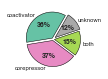

In [33]:
cofacs = cats_y2h[cats_y2h["partner_category"] == "cofactor"]

ys = np.array([len(cofacs[cofacs["cofactor_type"] == "coactivator"]), 
               len(cofacs[cofacs["cofactor_type"] == "corepressor"]),
               len(cofacs[cofacs["cofactor_type"] == "both"]),
               len(cofacs[cofacs["cofactor_type"] == "unknown"])])
labels = ["coactivator", "corepressor", "both", "unknown"]
colors = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[3], sns.color_palette("Set2")[4], "darkgray"]

fig, ax = plt.subplots(figsize=(1.2, 1.2), subplot_kw=dict(aspect="equal"))
ws, ls, ns = ax.pie(ys, colors=colors, labels=labels, autopct='%1.0f%%', startangle=60, 
                    explode=(0.05, 0.05, 0.05, 0.1))

for n, w in zip(ns, ws):
    w.set_linewidth(0.5)
    w.set_edgecolor("black")
    n.set_fontweight("bold")

fig.savefig("../../figures/fig4/PPIs-gene-level-manual-categories_cofactors.pdf", dpi="figure", bbox_inches="tight")

## 6. plot the relationship between gain/loss of PPIs and changes in activity

In [34]:
pairs = load_ref_vs_alt_isoforms_table()
tfs = load_annotated_TFiso1_collection()

reading from cache


In [35]:
def add_restricted_ppi_columns(pairs, rows, label):
    pairs_cf = pairs[['clone_acc_ref', 'clone_acc_alt']].copy()
    _add_PPI_columns(df=pairs_cf, y2h=y2h.loc[rows, :])
    return pd.merge(pairs, 
                    pairs_cf,
                    how='left',
                    on=['clone_acc_ref', 'clone_acc_alt'],
                    suffixes=('', '_' + label))

In [36]:
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(cofactor_partners),
                           label='cofactors'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(cofactor_animal_db),
                           label='cofactors_animal_db'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(coactivator_partners) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='coactivators_HEK'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(coactivator_partners) &
                                 ~y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='coactivators_not_HEK'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=~y2h['db_gene_symbol'].isin(cofactor_partners),
                           label='not_cofactors'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(coactivator_partners),
                           label='coactivators'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(corepressor_partners),
                           label='corepressors'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(corepressor_partners) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='corepressors_HEK'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(tf_gene_symbols),
                           label='tfs'
)

pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(signaling_partners) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='signaling_HEK'
)

In [37]:
def bar_activation_vs_ppi(x, y, pairs=pairs, x_label=None, y_label=None, color=None):
    """
    TODO:
        - calculate p-value properly
            - this requires permuting in some smart way
            - one question is whether the genes are the number of independent data points or the isoforms are
            - I think the answer is the isoforms are
    
    """
    df = pairs.copy()
    if x_label is None:
        x_label = x
    if y_label is None:
        y_label = y
    if color is None:
        color = sns.color_palette("Set2")[1]
    fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

    def bin_delta_ppi(delta_ppi):
        if pd.isnull(delta_ppi):
            return np.nan
        if delta_ppi < 0:
            return 'loss'
        elif delta_ppi > 0:
            return 'gain'
        elif delta_ppi == 0:
            return 'equal'
        else:
            raise ValueError(delta_ppi)


    df[x + '_binned'] = df[x].apply(bin_delta_ppi)
    sns.stripplot(data=df,
                  x=x + '_binned',
                  y=y,
                  order=['loss', 'equal', 'gain'],
                  alpha=0.75,
                  color=color,
                  linewidth=1,
                  edgecolor="black",
                  ax=ax)
    if False:
        sns.pointplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['loss', 'equal', 'gain'],
                    alpha=0.5,
                    color='black',
                    ax=ax)
    if True:
        sns.boxplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['loss', 'equal', 'gain'],
                    fliersize=0,
                    color=color,
                    ax=ax)
        mimic_r_boxplot(ax)
    else:
        sns.violinplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['loss', 'equal', 'gain'],
                    color='lightgrey',
                    ax=ax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    with_data = (df[x].notnull() & df[y].notnull())
    n_pair = with_data.sum()
    n_iso = len(set(df.loc[with_data, ['clone_acc_ref', 'clone_acc_alt']].values.flatten()))
    n_gene = df.loc[with_data, 'gene_symbol'].nunique()
    scc, p_scc = stats.spearmanr(df.loc[df[x].notnull() & df[y].notnull(), x].values,
                    df.loc[df[x].notnull() & df[y].notnull(), y].values)
    ax.text(s=f'{n_pair:d} pairs\n{n_iso:d} isoforms\n{n_gene:d} genes\nSpearman r = {scc:.2f}\np = {p_scc:.2f}',
            x=1.03,
            y=0.95,
            ha='left',
            va='top',
            transform=ax.transAxes)
    #ax.set_ylim(-4, 4) # NOTE cuts outlier TODO add broken axis
    ax.axhline(y=0, color='black', linestyle="dashed", linewidth=1)
    for pos in ['top', 'bottom', 'right']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    fig.savefig(f'../../figures/fig4/{x}-vs-{y}_scatter.pdf',
                bbox_inches='tight')

In [38]:
pairs['activation_abs_fold_change'] = pairs['activation_fold_change_log2'].abs()

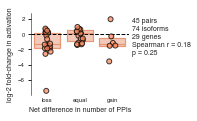

In [39]:
bar_activation_vs_ppi(
    pairs=pairs.loc[pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n',
    y='activation_fold_change_log2',
    x_label='Net difference in number of PPIs',
    y_label='log-2 fold-change in activation')

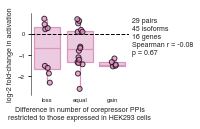

In [40]:
bar_activation_vs_ppi(
    pairs=pairs.loc[pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_corepressors_HEK',
    y='activation_fold_change_log2',
    x_label='Difference in number of corepressor PPIs\nrestricted to those expressed in HEK293 cells',
    y_label='log-2 fold-change in activation',
    color=sns.color_palette("Set2")[3])

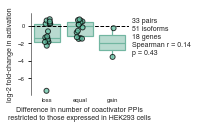

In [41]:
bar_activation_vs_ppi(
    pairs=pairs.loc[pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_coactivators',
    y='activation_fold_change_log2',
    x_label='Difference in number of coactivator PPIs\nrestricted to those expressed in HEK293 cells',
    y_label='log-2 fold-change in activation',
    color=sns.color_palette("Set2")[0])

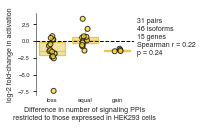

In [42]:
bar_activation_vs_ppi(
    pairs=pairs.loc[pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_signaling_HEK',
    y='activation_fold_change_log2',
    x_label='Difference in number of signaling PPIs\nrestricted to those expressed in HEK293 cells',
    y_label='log-2 fold-change in activation',
    color=sns.color_palette("Set2")[5])

In [43]:
pairs[pairs['gene_symbol'] == 'TCF4'].sort_values(by='activation_fold_change_log2')[['clone_acc_ref',
                                                                                     'clone_acc_alt',
                                                                                     'at_least_one_isoform_in_gene_abs_activation_gte_2fold',
                                                                                     'PPI_delta_n_coactivators_HEK',
                                                                                     'activation_fold_change_log2']]

,clone_acc_ref,clone_acc_alt,at_least_one_isoform_in_gene_abs_activation_gte_2fold,PPI_delta_n_coactivators_HEK,activation_fold_change_log2
358,TCF4|1/9|07E01,TCF4|6/9|07H03,True,-4.0,-1.598357
357,TCF4|1/9|07E01,TCF4|5/9|07C02,True,-3.0,-1.369125
354,TCF4|1/9|07E01,TCF4|2/9|07E03,True,0.0,0.102610
360,TCF4|1/9|07E01,TCF4|8/9|07A05,True,-3.0,0.455881
355,TCF4|1/9|07E01,TCF4|3/9|07C04,True,0.0,0.621134
356,TCF4|1/9|07E01,TCF4|4/9|07G02,True,0.0,0.699990
359,TCF4|1/9|07E01,TCF4|7/9|07G03,True,-3.0,0.721583
